In [379]:
import yfinance as yf
import pandas as pd
import numpy as np
from deap import base, creator, gp, tools
from scipy.stats import spearmanr
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from itertools import product
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
def ts_mean(series, window):
    return series.rolling(window).mean().fillna(0)

def ts_rank(series, window):
    return series.rolling(window).apply(lambda x: pd.Series(x).rank().iloc[-1]).fillna(0)

def ts_std(series, window):
    return series.rolling(window).std().fillna(0)

def ts_corr(series1, series2, window):
    return series1.rolling(window).corr(series2).fillna(0)

def ts_max(series, window):
    return series.rolling(window).max().fillna(0)

def ts_min(series, window):
    return series.rolling(window).min().fillna(0)

def safe_divide(left, right):
    return np.divide(left, right, out=np.zeros_like(left), where=right != 0)

In [60]:
def download_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        if not df.empty:
            data[ticker] = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

def get_tickers():
    sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

    market_caps = []
    for ticker in sp500_tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            if "marketCap" in info:
                market_caps.append((ticker, info["marketCap"]))
        except Exception as e:
            continue

    sorted_by_market_cap = sorted(market_caps, key=lambda x: x[1], reverse=True)[:100]
    return [ticker for ticker, _ in sorted_by_market_cap]

tickers = get_tickers()
start = "2024-08-01"
end = "2024-11-30"
data = download_data(tickers, start, end)

In [181]:
def setup():   
    pset = gp.PrimitiveSet("MAIN", 20)
    pset.renameArguments(
        ARG0="PriceMomentum5", ARG1="VolumeMomentum5", ARG2="Volatility5",
        ARG3="PriceVolumeCorr5", ARG4="Channel5", ARG5="RSI5", ARG6="Bollinger5",
        ARG7="PriceMomentum10", ARG8="VolumeMomentum10", ARG9="Volatility10",
        ARG10="PriceVolumeCorr10", ARG11="Channel10", ARG12="RSI10", ARG13="Bollinger10",
        ARG14="VolumeImbalance", ARG15="High", ARG16="Open", ARG17="Low", ARG18="Close", ARG19="Volume"
    )

    pset.addPrimitive(np.add, 2, name="add")
    pset.addPrimitive(np.subtract, 2, name="subtract")
    pset.addPrimitive(np.multiply, 2, name="multiply")
    pset.addPrimitive(safe_divide, 2, name="div")
    pset.addPrimitive(np.negative, 1, name="neg")
    pset.addPrimitive(np.sqrt, 1, name="sqrt")
    pset.addPrimitive(np.maximum, 2, name="max")
    pset.addPrimitive(np.minimum, 2, name="min")
    
    pset.addPrimitive(lambda x: ts_mean(x, 5), 1, name="ts_mean_5")
    pset.addPrimitive(lambda x: ts_std(x, 5), 1, name="ts_std_5")
    pset.addPrimitive(lambda x: ts_rank(x, 5), 1, name="ts_rank_5")
    pset.addPrimitive(lambda x, y: ts_corr(x, y, 5), 2, name="ts_corr_5")
    pset.addPrimitive(lambda x: ts_max(x, 5), 1, name="ts_max_5")
    pset.addPrimitive(lambda x: ts_min(x, 5), 1, name="ts_min_5")
    
    pset.addPrimitive(lambda x: ts_mean(x, 10), 1, name="ts_mean_10")
    pset.addPrimitive(lambda x: ts_std(x, 10), 1, name="ts_std_10")
    pset.addPrimitive(lambda x: ts_rank(x, 10), 1, name="ts_rank_10")
    pset.addPrimitive(lambda x, y: ts_corr(x, y, 10), 2, name="ts_corr_10")
    pset.addPrimitive(lambda x: ts_max(x, 10), 1, name="ts_max_10")
    pset.addPrimitive(lambda x: ts_min(x, 10), 1, name="ts_min_10")

    pset.addEphemeralConstant("rand", lambda: np.random.uniform(-1, 1))
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=2, max_=3)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)
    
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
    toolbox.register("select", tools.selTournament, tournsize=3)
    return toolbox, pset

def fitness_ic(individual, data, toolbox, window=10):
    compiled_expr = toolbox.compile(expr=individual)
    all_ic = []

    for date in data[list(data.keys())[0]].index:
        try:
            cross_section = []
            
            for ticker, df in data.items():
                if date in df.index:
                    window_data = df.loc[:date].tail(window)

                    feature_values = compiled_expr(
                        window_data['PriceMomentum5'],
                        window_data['VolumeMomentum5'],
                        window_data['Volatility5'],
                        window_data['PriceVolumeCorr5'],
                        window_data['Channel5'],
                        window_data['RSI5'],
                        window_data['Bollinger5'],
                        window_data['PriceMomentum10'],
                        window_data['VolumeMomentum10'],
                        window_data['Volatility10'],
                        window_data['PriceVolumeCorr10'],
                        window_data['Channel10'],
                        window_data['RSI10'],
                        window_data['Bollinger10'],
                        window_data['VolumeImbalance'],
                        window_data['High'],
                        window_data['Open'],
                        window_data['Low'],
                        window_data['Close'],
                        window_data['Volume']
                    )

                    cross_section.append((feature_values.iloc[-1], df.loc[date, 'Return']))
            
            if len(cross_section) > 1:
                features, targets = zip(*cross_section)
                corr, _ = spearmanr(features, targets)
                if not np.isnan(corr):
                    all_ic.append(corr)
        
        except Exception as e:
            continue

    return np.nanmean(all_ic) if all_ic else 0,

def fitness_sharpe(individual, data, toolbox, window=10):
    compiled_expr = toolbox.compile(expr=individual)
    portfolio_returns = []

    for date in data[list(data.keys())[0]].index[window:]:
        try:
            daily_returns = []
            for ticker, df in data.items():
                if date in df.index:
                    window_data = df.loc[:date].tail(window)
                    
                    factor_value = compiled_expr(
                        window_data['PriceMomentum5'],
                        window_data['VolumeMomentum5'],
                        window_data['Volatility5'],
                        window_data['PriceVolumeCorr5'],
                        window_data['Channel5'],
                        window_data['RSI5'],
                        window_data['Bollinger5'],
                        window_data['PriceMomentum10'],
                        window_data['VolumeMomentum10'],
                        window_data['Volatility10'],
                        window_data['PriceVolumeCorr10'],
                        window_data['Channel10'],
                        window_data['RSI10'],
                        window_data['Bollinger10'],
                        window_data['VolumeImbalance'],
                        window_data['High'],
                        window_data['Open'],
                        window_data['Low'],
                        window_data['Close'],
                        window_data['Volume']
                    )
                    daily_returns.append((ticker, factor_value.iloc[-1], df.loc[date, 'Return']))
            
            if len(daily_returns) >= 40:
                daily_returns = sorted(daily_returns, key=lambda x: x[1])
                long_portfolio = [x[2] for x in daily_returns[-20:]]
                short_portfolio = [x[2] for x in daily_returns[:20]]
                portfolio_return = np.mean(long_portfolio) - np.mean(short_portfolio)
                portfolio_returns.append(portfolio_return)
        except Exception as e:
            continue
            
    if len(portfolio_returns) > 0:
        mean_return = np.mean(portfolio_returns)
        std_return = np.std(portfolio_returns)
        sharpe_ratio = mean_return / std_return if std_return != 0 else 0
        return sharpe_ratio,
    else:
        return 0,

def run_evolution(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    for gen in range(1, ngen + 1):
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if np.random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        population[:] = offspring
        if halloffame is not None:
            halloffame.update(population)

        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

def preprocess_data(data):
    processed_data = {}
    for ticker, df in data.items():
        df['PriceMomentum5'] = ts_mean(df['Close'], 5) - df['Close']
        df['VolumeMomentum5'] = ts_mean(df['Volume'], 5) - df['Volume']
        df['Volatility5'] = ts_std(df['Close'], 5)
        df['PriceVolumeCorr5'] = ts_corr(df['Close'], df['Volume'], 5)
        df['Channel5'] = ts_max(df['High'], 5) - ts_min(df['Low'], 5)        
        df['RSI5'] = 100 - (100 / (1 + (df['Close'].diff().clip(lower=0).rolling(5).mean() /
                                         df['Close'].diff().clip(upper=0).abs().rolling(5).mean())))
        df['Bollinger5'] = ts_std(df['Close'], 5) / ts_mean(df['Close'], 5)
        
        df['PriceMomentum10'] = ts_mean(df['Close'], 10) - df['Close']
        df['VolumeMomentum10'] = ts_mean(df['Volume'], 10) - df['Volume']
        df['Volatility10'] = ts_std(df['Close'], 10)
        df['PriceVolumeCorr10'] = ts_corr(df['Close'], df['Volume'], 10)
        df['Channel10'] = ts_max(df['High'], 10) - ts_min(df['Low'], 10)
        df['RSI10'] = 100 - (100 / (1 + (df['Close'].diff().clip(lower=0).rolling(10).mean() /
                                         df['Close'].diff().clip(upper=0).abs().rolling(10).mean())))
        df['Bollinger10'] = ts_std(df['Close'], 10) / ts_mean(df['Close'], 10)
        
        df['VolumeImbalance'] = (df['Close'] - df['Open']) / (df['High'] - df['Low']) * df['Volume']
        
        df['Return'] = df['Close'].shift(-1) / df['Open'].shift(-1) - 1
        processed_data[ticker] = df.dropna()
    return processed_data

def run(data, n=10, generations=10, cxpb=0.7, mutpb=0.3):
    processed_data = preprocess_data(data)

    toolbox, pset = setup()
    population = toolbox.population(n=n)
    generations = generations
    hof = tools.HallOfFame(1)

    fitness_func = partial(fitness_sharpe, data=processed_data, toolbox=toolbox)
    toolbox.register("evaluate", fitness_func)
    
    run_evolution(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=generations, stats=None, halloffame=hof, verbose=True)

    print("Best Expression:", hof[0])
    print("Best Fitness:", fitness_func(hof[0])[0])
    return hof

In [205]:
hof = run(data, n=10, generations=10, cxpb=0.7, mutpb=0z.3)

gen	nevals
0  	10    
1  	8     
2  	7     
3  	8     
4  	10    
5  	8     
6  	8     
7  	6     
8  	8     
9  	7     
10 	7     
Best Expression: div(ts_corr_10(multiply(Volatility5, Close), multiply(Low, Volatility5)), min(ts_rank_10(Volatility5), ts_rank_5(Channel10)))
Best Fitness: 0.4772846436378001


Annualized Return: 0.5203117294623718
Sharpe Ratio: 6.996567644684914


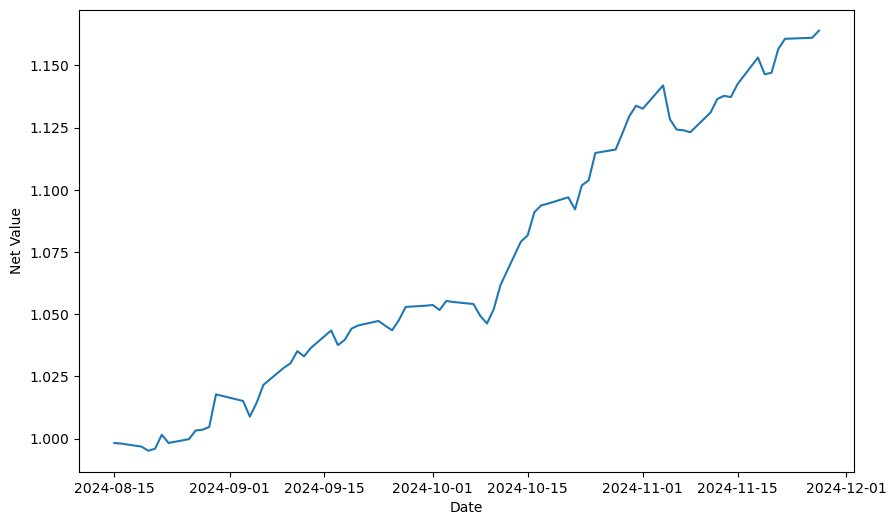

In [389]:
alpha = 'div(ts_corr_10(multiply(Volatility5, Close), multiply(Low, Volatility5)), min(ts_rank_10(Volatility5), ts_rank_5(Channel10)))'

processed_data = preprocess_data(data)
processed_data = calculate_factor(processed_data, alpha)
net_value, annualized_return, sharpe_ratio = backtest(processed_data)

print("Annualized Return:", annualized_return)
print("Sharpe Ratio:", sharpe_ratio)

plt.figure(figsize=(10, 6))
plt.plot(net_value.index, net_value['NetValue'])
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.show()

In [368]:
def define_window_function():
    global ts_mean_5, ts_mean_10, ts_std_5, ts_std_10, ts_rank_5, ts_rank_10, ts_corr_5, ts_corr_10, ts_max_5, ts_max_10, ts_min_5, ts_min_10, add, subtract, multiply, div, neg, sqrt, max, min

    ts_mean_5 = lambda series: ts_mean(series, 5)
    ts_mean_10 = lambda series: ts_mean(series, 10)
    ts_std_5 = lambda series: ts_std(series, 5)
    ts_std_10 = lambda series: ts_std(series, 10)
    ts_rank_5 = lambda series: ts_rank(series, 5)
    ts_rank_10 = lambda series: ts_rank(series, 10)
    ts_corr_5 = lambda series1, series2: ts_corr(series1, series2, 5)
    ts_corr_10 = lambda series1, series2: ts_corr(series1, series2, 10)
    ts_max_5 = lambda series: ts_max(series, 5)
    ts_max_10 = lambda series: ts_max(series, 10)
    ts_min_5 = lambda series: ts_min(series, 5)
    ts_min_10 = lambda series: ts_min(series, 10)
    
    add = np.add
    subtract = np.subtract
    multiply = np.multiply
    div = safe_divide
    neg = np.negative
    sqrt = np.sqrt
    max = np.maximum
    min = np.minimum
    
def calculate_factor(processed_data, alpha_expression):
    for ticker, df in processed_data.items():
        local_vars = {col: df[col] for col in df.columns}
        processed_data[ticker]['Factor'] = eval(alpha_expression, globals(), local_vars)
        processed_data[ticker]['Factor'].replace([float('inf'), float('-inf')], 0, inplace=True)
        processed_data[ticker]['Factor'].fillna(0, inplace=True)
    return processed_data

def backtest(processed_data):
    combined_df = pd.DataFrame()
    for ticker, df in processed_data.items():
        df = df[['Factor', 'Return']].copy()
        df['Ticker'] = ticker
        combined_df = pd.concat([combined_df, df])

    combined_df.reset_index(inplace=True)
    combined_df.rename(columns={'index': 'Date'}, inplace=True)
    grouped = combined_df.groupby('Date')

    net_value = 1
    net_value_series = []
    daily_returns = []
    for date, group in grouped:
        group = group.sort_values(by='Factor', ascending=False)
        long_group = group.head(20)
        short_group = group.tail(20)

        long_return = long_group['Return'].mean()
        short_return = short_group['Return'].mean()
        daily_return = long_return - short_return
        daily_returns.append(daily_return)

        net_value *= (1 + daily_return)
        net_value_series.append({'Date': date, 'NetValue': net_value})

    net_value_df = pd.DataFrame(net_value_series)
    net_value_df.set_index('Date', inplace=True)
    
    trading_days_per_year = 252
    cumulative_return = net_value / net_value_df.iloc[0]['NetValue'] - 1
    annualized_return = np.mean(daily_returns) * trading_days_per_year
    annualized_volatility = np.std(daily_returns) * np.sqrt(trading_days_per_year)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0

    return net_value_df, annualized_return, sharpe_ratio

div(ts_corr_10(multiply(Volatility5, Close), multiply(Low, Volatility5)), min(ts_rank_10(Volatility5), ts_rank_5(Channel10)))  

multiply(max(subtract(PriceVolumeCorr10, ts_rank_5(ts_std_10(sqrt(RSI10)))), ts_corr_10(High, PriceMomentum5)), ts_rank_10(max(subtract(PriceVolumeCorr10, ts_corr_10(High, PriceMomentum5)), ts_corr_10(High, PriceMomentum5))))  

ts_rank_5(ts_max_5(neg(RSI5)))  
 
ts_corr_10(ts_corr_10(RSI10, Channel5), ts_rank_5(PriceMomentum5))

ts_min_5(add(neg(ts_rank_5(Bollinger10)), PriceMomentum10))
    
ts_max_5(min(VolumeMomentum10, min(ts_corr_5(Close, PriceMomentum10), PriceMomentum10)))

ts_rank_10(multiply(subtract(VolumeMomentum5, Channel5), subtract(ts_max_5(ts_corr_5(VolumeImbalance, ts_mean_10(Open))), Channel5)))

ts_mean_10(add(div(RSI10, PriceVolumeCorr5), Bollinger5))

multiply(subtract(Channel5, 0.5), neg(add(Channel5, Channel10)))

ts_mean_5(VolumeMomentum5)

alpha1
Annualized Return: 0.5203117294623718
Sharpe Ratio: 6.996567644684914
alpha2
Annualized Return: 0.4205268430092931
Sharpe Ratio: 5.95630081236738
alpha3
Annualized Return: 0.2593021608930008
Sharpe Ratio: 3.109637017561453
alpha4
Annualized Return: 0.21970863635448845
Sharpe Ratio: 3.7423994806900835
alpha5
Annualized Return: 0.3145878769765717
Sharpe Ratio: 3.0787426056889102
alpha6
Annualized Return: 0.3823042141288243
Sharpe Ratio: 5.05276933757029
alpha7
Annualized Return: 0.2627379284656187
Sharpe Ratio: 4.254549066942231
alpha8
Annualized Return: 0.19798801402739968
Sharpe Ratio: 3.3018237237791848
alpha9
Annualized Return: 0.34205033481868713
Sharpe Ratio: 3.186743547306696
alpha10
Annualized Return: 0.2574617270933481
Sharpe Ratio: 2.971321047915226


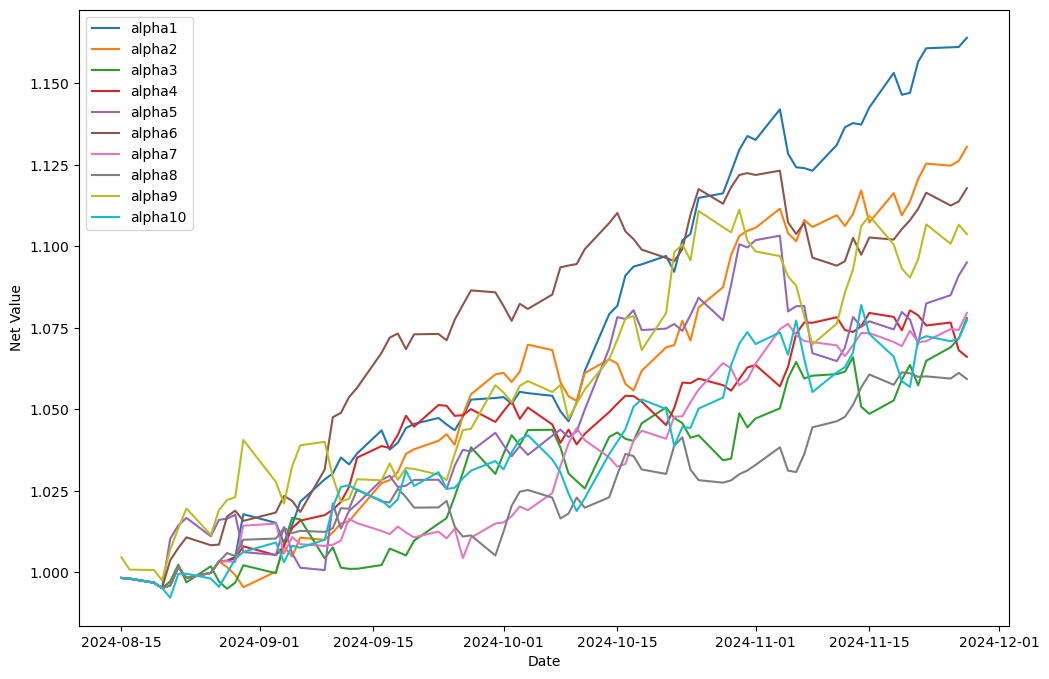

In [370]:
alphas = {
    "alpha1": 'div(ts_corr_10(multiply(Volatility5, Close), multiply(Low, Volatility5)), min(ts_rank_10(Volatility5), ts_rank_5(Channel10)))',
    "alpha2": 'multiply(max(subtract(PriceVolumeCorr10, ts_rank_5(ts_std_10(sqrt(RSI10)))), ts_corr_10(High, PriceMomentum5)), ts_rank_10(max(subtract(PriceVolumeCorr10, ts_corr_10(High, PriceMomentum5)), ts_corr_10(High, PriceMomentum5))))',
    "alpha3": 'ts_rank_5(ts_max_5(neg(RSI5)))',
    "alpha4": 'ts_corr_10(ts_corr_10(RSI10, Channel5), ts_rank_5(PriceMomentum5))',
    "alpha5": 'ts_min_5(add(neg(ts_rank_5(Bollinger10)), PriceMomentum10))',
    "alpha6": 'ts_max_5(min(VolumeMomentum10, min(ts_corr_5(Close, PriceMomentum10), PriceMomentum10)))',
    "alpha7": 'ts_rank_10(multiply(subtract(VolumeMomentum5, Channel5), subtract(ts_max_5(ts_corr_5(VolumeImbalance, ts_mean_10(Open))), Channel5)))',
    "alpha8": 'ts_mean_10(add(div(RSI10, PriceVolumeCorr5), Bollinger5))',
    "alpha9": 'multiply(subtract(Channel5, 0.5), neg(add(Channel5, Channel10)))',
    "alpha10": 'ts_mean_5(VolumeMomentum5)'
}

processed_data = preprocess_data(data)
define_window_function()

net_values = {}

for alpha_name, alpha_expression in alphas.items():
    print(alpha_name)
    processed_data = calculate_factor(processed_data, alpha_expression)
    net_value, annualized_return, sharpe_ratio = backtest(processed_data)
    print("Annualized Return:", annualized_return)
    print("Sharpe Ratio:", sharpe_ratio)
    net_values[alpha_name] = net_value

plt.figure(figsize=(12, 8))
for alpha_name, net_value in net_values.items():
    plt.plot(net_value.index, net_value['NetValue'], label=alpha_name)

plt.xlabel('Date')
plt.ylabel('Net Value')
plt.legend()
plt.show()

In [371]:
def scale(series):
    min_val = series.min()
    max_val = series.max()
    if max_val - min_val == 0:
        return series * 0
    return (series - min_val) / (max_val - min_val)

def zscore(series):
    mean_val = series.mean()
    std_val = series.std()
    if std_val == 0:
        return series * 0
    return (series - mean_val) / std_val

def scale_factor(processed_data, factor_name):
    for date in processed_data[list(processed_data.keys())[0]].index:
        cross_section = []
        for ticker, df in processed_data.items():
            if date in df.index:
                cross_section.append((ticker, df.loc[date, factor_name]))

        if cross_section:
            df_cross_section = pd.DataFrame(cross_section, columns=["Ticker", factor_name])
            df_cross_section[factor_name] = scale(df_cross_section[factor_name])

            for _, row in df_cross_section.iterrows():
                processed_data[row["Ticker"]].loc[date, factor_name] = row[factor_name]
    return processed_data

def zscore_factor(processed_data, factor_name):
    for date in processed_data[list(processed_data.keys())[0]].index:
        cross_section = []
        for ticker, df in processed_data.items():
            if date in df.index:
                cross_section.append((ticker, df.loc[date, factor_name]))

        if cross_section:
            df_cross_section = pd.DataFrame(cross_section, columns=["Ticker", factor_name])
            df_cross_section[factor_name] = zscore(df_cross_section[factor_name])

            for _, row in df_cross_section.iterrows():
                processed_data[row["Ticker"]].loc[date, factor_name] = row[factor_name]
    return processed_data

processed_data = preprocess_data(data)
define_window_function()

for alpha_name, alpha_expression in alphas.items():
    processed_data = calculate_factor(processed_data, alpha_expression)
    processed_data = zscore_factor(processed_data, "Factor")
    for ticker, df in processed_data.items():
        df[alpha_name] = df['Factor']

In [392]:
def combine_factors(processed_data, factor_names, weights):
    combined_name = "Factor"
    for ticker, df in processed_data.items():
        combined_factor = sum(
            weight * df[factor_name] for weight, factor_name in zip(weights, factor_names)
        )
        processed_data[ticker][combined_name] = combined_factor
    return processed_data

def round_weights(weights):
    rounded_weights = np.round(weights, 2)
    correction = 1 - np.sum(rounded_weights)
    if correction != 0:
        max_index = np.argmax(rounded_weights)
        rounded_weights[max_index] += correction 
    return rounded_weights

def greedy_optimize(processed_data, alphas, weight_range=np.arange(0, 1.1, 0.05)):
    alpha_names = list(alphas.keys())
    num_alphas = len(alpha_names)
    best_weights = [1] + [0] * (num_alphas - 1)
    best_sharpe = -np.inf

    for i in range(1, num_alphas):
        current_best_sharpe = -np.inf
        current_best_weight = None
        for weight in weight_range:
            weights = best_weights.copy()
            weights[i] = weight
            weights = np.array(weights) / np.sum(weights)
            
            processed_data = combine_factors(processed_data, alpha_names, weights)

            net_value, annualized_return, sharpe_ratio = backtest(processed_data)
            
            if sharpe_ratio > current_best_sharpe:
                current_best_sharpe = sharpe_ratio
                current_best_weight = weight

        best_weights[i] = current_best_weight
        best_weights = np.array(best_weights) / np.sum(best_weights)

        if current_best_sharpe > best_sharpe:
            best_sharpe = current_best_sharpe
    
    return best_weights, best_sharpe

best_weights, best_sharpe = greedy_optimize(processed_data, alphas)

print("Best Weights:", best_weights)
print("Best Sharpe Ratio:", best_sharpe)

Best Weights: [0.11213905 0.05606953 0.         0.         0.         0.17661901
 0.34482759 0.31034483 0.         0.        ]
Best Sharpe Ratio: 8.446182333236784


Annualized Return: 0.5180418372369247
Sharpe Ratio: 8.446182333236784


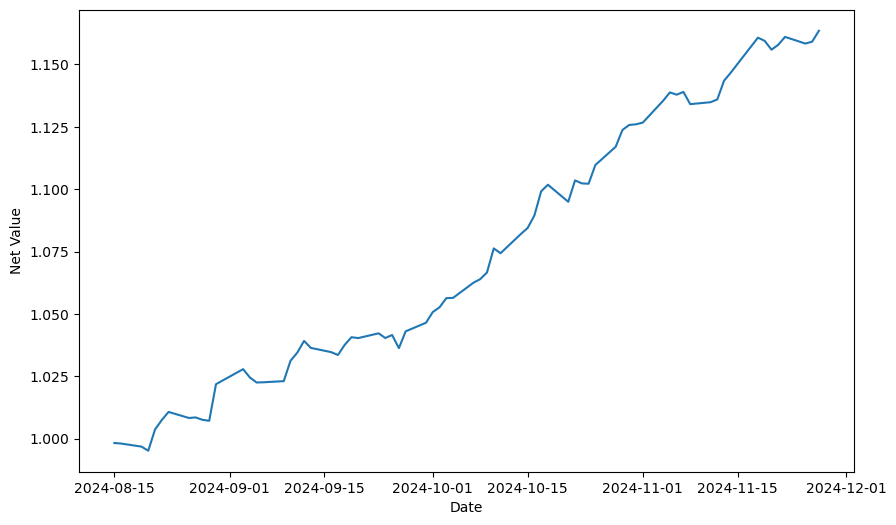

In [378]:
best_alpha = combine_factors(processed_data, list(alphas.keys()), best_weights)
net_value, annualized_return, sharpe_ratio = backtest(best_alpha)

print("Annualized Return:", annualized_return)
print("Sharpe Ratio:", sharpe_ratio)

plt.figure(figsize=(10, 6))
plt.plot(net_value.index, net_value['NetValue'])
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.show()

In [398]:
def objective_function(weights, processed_data, alpha_names):
    weights = np.array(weights)
    weights = weights / np.sum(weights)
    processed_data = combine_factors(processed_data, alpha_names, weights)
    _, _, sharpe_ratio = backtest(processed_data)
    return -sharpe_ratio

def constraint_sum_to_one(weights):
    return np.sum(weights) - 1

def global_optimize(processed_data, alphas):
    alpha_names = list(alphas.keys())
    num_alphas = len(alpha_names)

    initial_weights = np.array(best_weights)

    constraints = [{'type': 'eq', 'fun': constraint_sum_to_one}]

    bounds = [(0, 1) for _ in range(num_alphas)]

    result = minimize(
        objective_function,
        initial_weights,
        args=(processed_data, alpha_names),
        bounds=bounds,
        constraints=constraints,
        method='SLSQP'
    )

    if result.success:
        optimal_weights = result.x
        optimal_sharpe = -result.fun
        return optimal_weights, optimal_sharpe
    else:
        raise ValueError("Optimization failed:", result.message)

best_weights, best_sharpe = global_optimize(processed_data, alphas)

print("Best Weights:", best_weights)
print("Best Sharpe Ratio:", best_sharpe)

Best Weights: [0.11213905 0.05606953 0.         0.         0.         0.17661901
 0.34482759 0.31034483 0.         0.        ]
Best Sharpe Ratio: 8.446182333236784


In [412]:
def refine_global_optimize(processed_data, alphas, iterations=10):
    alpha_names = list(alphas.keys())
    num_alphas = len(alpha_names)
    best_sharpe = -np.inf
    best_weights = None

    for _ in range(iterations):
        initial_weights = [0.11213905, 0.05606953, 0., 0., 0., 0.17661901, 0.34482759, 0.31034483, 0., 0.]
        initial_weights += 0.1 * np.random.dirichlet(np.ones(num_alphas), size=1)[0]
        initial_weights /= sum(initial_weights)

        result = minimize(
            objective_function,
            initial_weights,
            args=(processed_data, alpha_names),
            bounds=[(0, 1) for _ in range(num_alphas)],
            constraints=[{'type': 'eq', 'fun': constraint_sum_to_one}],
            method='SLSQP',
            options={'xtol': 1e-10, 'gtol': 1e-10, 'disp': False}
        )

        if result.success and -result.fun > best_sharpe:
            best_sharpe = -result.fun
            best_weights = result.x

    if best_weights is not None:
        refined_result = minimize(
            objective_function,
            best_weights,
            args=(processed_data, alpha_names),
            bounds=[(0, 1) for _ in range(num_alphas)],
            constraints=[{'type': 'eq', 'fun': constraint_sum_to_one}],
            method='trust-constr',
            options={'xtol': 1e-10, 'gtol': 1e-10, 'disp': False}
        )

        if refined_result.success and -refined_result.fun > best_sharpe:
            best_sharpe = -refined_result.fun
            best_weights = refined_result.x

    return best_weights, best_sharpe

best_weights, best_sharpe = refine_global_optimize(processed_data, alphas, iterations=20)

print("Best Weights:", best_weights)
print("Best Sharpe Ratio:", best_sharpe)

Best Weights: [0.1047485  0.06777605 0.01190472 0.00424642 0.01383934 0.16672677
 0.33459559 0.28335209 0.00709574 0.00571476]
Best Sharpe Ratio: 8.081717761675916


In [440]:
def grid_search_optimize(processed_data, alphas, step=0.1):
    alpha_names = list(alphas.keys())
    num_alphas = len(alpha_names)
    weight_range = np.arange(0, 1 + step, step)

    best_weights = None
    best_sharpe = -np.inf

    total_combinations = len(weight_range) ** num_alphas

    for weights in tqdm(product(weight_range, repeat=num_alphas), total=total_combinations, desc="Grid Search Progress"):
        weights = np.array(weights)
        if not np.isclose(weights.sum(), 1):
            continue

        combined_data = combine_factors(processed_data, alpha_names, weights)
        net_value, _, sharpe_ratio = backtest(combined_data)

        if sharpe_ratio > best_sharpe:
            best_sharpe = sharpe_ratio
            best_weights = weights
            
    best_weights /= np.sum(best_weights)
    return best_weights, best_sharpe
    
step_size = 0.2
best_weights, best_sharpe = grid_search_optimize(processed_data, alphas, step=step_size)

print("Best Weights:", best_weights)
print("Best Sharpe Ratio:", best_sharpe)

Grid Search Progress: 100%|████████████████████████████████████████████████████████| 60466176/60466176 [17:56<00:00, 56182.07it/s]

Best Weights: [0.  0.2 0.  0.2 0.  0.  0.4 0.2 0.  0. ]
Best Sharpe Ratio: 9.305815339732797


Annualized Return: 0.5588185229487538
Sharpe Ratio: 9.305815339732797


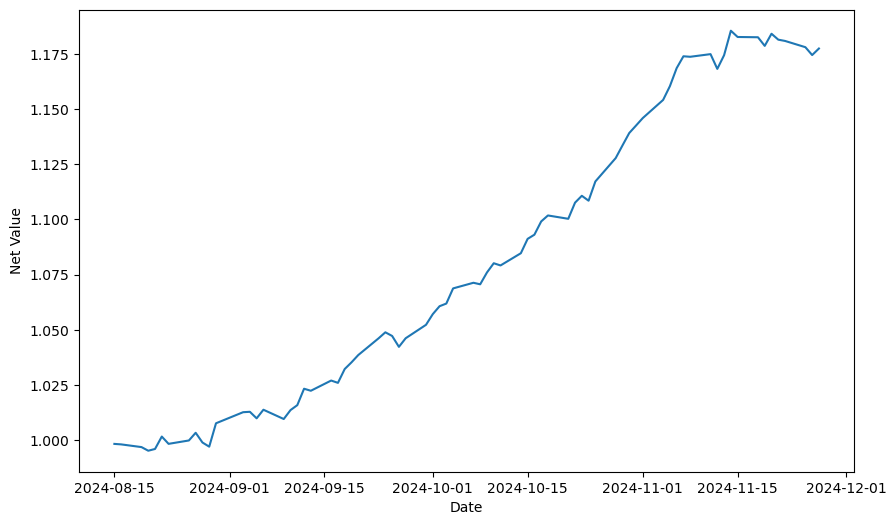

In [448]:
best_weights = [0., 0.2, 0., 0.2, 0., 0., 0.4, 0.2, 0., 0.]
best_alpha = combine_factors(processed_data, list(alphas.keys()), best_weights)
net_value, annualized_return, sharpe_ratio = backtest(best_alpha)

print("Annualized Return:", annualized_return)
print("Sharpe Ratio:", sharpe_ratio)

plt.figure(figsize=(10, 6))
plt.plot(net_value.index, net_value['NetValue'])
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.show()

In [439]:
start = "2024-12-01"
end = "2025-01-05"
data_oos = download_data(tickers, start, end)

Annualized Return: 0.32876750119482684
Sharpe Ratio: 6.911474268650577


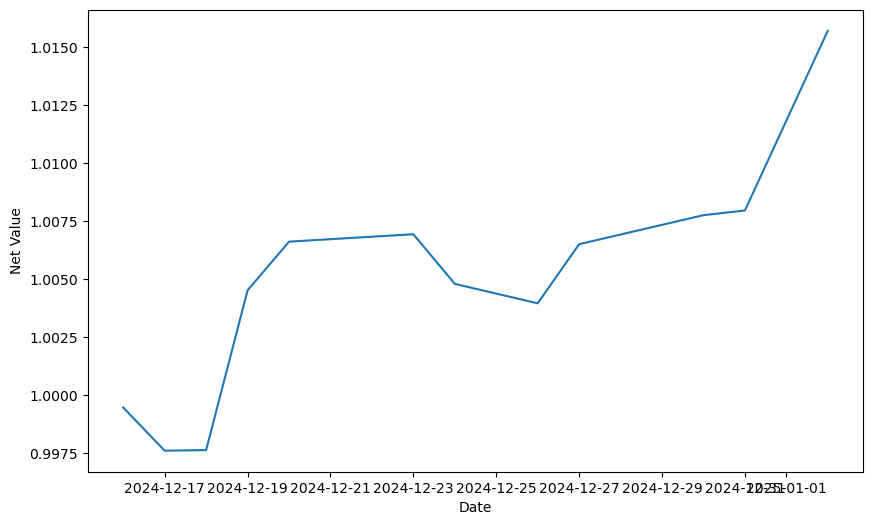

In [441]:
processed_data_oos = preprocess_data(data_oos)

for alpha_name, alpha_expression in alphas.items():
    processed_data_oos = calculate_factor(processed_data_oos, alpha_expression)
    processed_data_oos = zscore_factor(processed_data_oos, "Factor")
    for ticker, df in processed_data_oos.items():
        df[alpha_name] = df['Factor']

best_weights = [0.11213905, 0.05606953, 0., 0., 0., 0.17661901, 0.34482759, 0.31034483, 0., 0.]
best_weights = [0., 0.2, 0., 0.2, 0., 0., 0.4, 0.2, 0., 0.]

best_alpha = combine_factors(processed_data_oos, list(alphas.keys()), best_weights)

net_value, annualized_return, sharpe_ratio = backtest(best_alpha)

print("Annualized Return:", annualized_return)
print("Sharpe Ratio:", sharpe_ratio)

plt.figure(figsize=(10, 6))
plt.plot(net_value.index, net_value['NetValue'])
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.show()